<a href="https://colab.research.google.com/github/rebal-akar/MLCW2/blob/main/Fully_Supervised_w_Embeddings_%5BImprovement%5D_ML_CW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Self-supervised


Imports

In [2]:
# ⚙️ Core Python & OS
import os
import math
import random

# 📦 PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

# 📊 Data Science
import numpy as np
import pandas as pd
from tqdm import tqdm

# 📈 Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import csv

# 🤖 ML Tools
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE


Cell 2: Load Pre-trained SimCLR Model

In [3]:
class SimCLRModel(nn.Module):
    def __init__(self):
        super(SimCLRModel, self).__init__()
        resnet = models.resnet18(pretrained=False)
        resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        resnet.maxpool = nn.Identity()
        resnet.fc = nn.Identity()
        self.encoder = resnet
        self.projector = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 128)
        )

    def forward(self, x, return_embedding=False):
        h = self.encoder(x)
        h = torch.flatten(h, 1)
        if return_embedding:
            return h
        return self.projector(h)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimCLRModel().to(device)

model_path = "/content/drive/MyDrive/Typiclust/simclr_cifar-10.pth"
checkpoint = torch.load(model_path, map_location=device)

from collections import OrderedDict
new_state_dict = OrderedDict()
for key, value in checkpoint.items():
    if key.startswith("backbone."):
        new_key = "encoder." + key[len("backbone."):]
    elif key.startswith("contrastive_head."):
        new_key = "projector." + key[len("contrastive_head."):]
    else:
        new_key = key
    if "shortcut" in new_key:
        new_key = new_key.replace("shortcut", "downsample")
    new_state_dict[new_key] = value

missing_keys, unexpected_keys = model.load_state_dict(new_state_dict, strict=False)
print("Missing keys:", missing_keys)
print("Unexpected keys:", unexpected_keys)
model.eval()
print("✅ Pretrained SimCLR model loaded successfully!")




/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Missing keys: []
Unexpected keys: []
✅ Pretrained SimCLR model loaded successfully!


Cell 3: Data Preparation – Load CIFAR-10 Dataset

In [4]:

# Define transforms; ensure normalization matches SimCLR training

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("CIFAR-10 data loaded.")


100%|██████████| 170M/170M [00:02<00:00, 73.4MB/s]


CIFAR-10 data loaded.


Cell 4: Extract Embeddings Using the Pre-trained Model

In [5]:


embeddings_path = "embeddings.npy"
indices_path = "indices.npy"

def extract_embeddings(model, loader):
    model.eval()
    all_embeddings = []
    all_indices = []
    with torch.no_grad():
        for i, (images, _) in enumerate(tqdm(loader, desc="Extracting embeddings")):
            images = images.to(device)
            feats = model(images, return_embedding=True)
            feats = feats.cpu().numpy()
            # L2-normalize the extracted features
            norms = np.linalg.norm(feats, axis=1, keepdims=True) + 1e-8
            feats = feats / norms
            all_embeddings.append(feats)
            start_idx = i * batch_size
            end_idx = start_idx + images.size(0)
            all_indices.extend(range(start_idx, end_idx))
    embeddings = np.concatenate(all_embeddings, axis=0)
    return embeddings, all_indices

embeddings, indices = extract_embeddings(model, train_loader)
np.save(embeddings_path, embeddings)
np.save(indices_path, indices)
print("Feature extraction complete. Embeddings shape:", embeddings.shape)



Extracting embeddings: 100%|██████████| 391/391 [00:11<00:00, 34.49it/s]


Feature extraction complete. Embeddings shape: (50000, 512)


Cell 5: Clustering and Computing Typicality

In [6]:


def compute_typicality_nn(cluster_features, K=20):
    """
    Compute typicality as the inverse of the average Euclidean distance
    to the min{20, cluster_size} nearest neighbors (excluding the point itself).
    """
    n = cluster_features.shape[0]
    if n == 0:
        return np.array([])
    nbrs = NearestNeighbors(n_neighbors=min(K+1, n), algorithm='auto',metric='euclidean').fit(cluster_features)
    distances, _ = nbrs.kneighbors(cluster_features)
    avg_distances = np.mean(distances[:, 1:], axis=1)
    typicality = 1.0 / (avg_distances + 1e-8)
    return typicality

def typiclust_pool_selection_batch(unlabeled_embeddings, unlabeled_ids, budget, max_clusters, labeled_embeddings, labeled_ids):
    """
    Batch-select query samples from the unlabeled pool based on clustering and typicality,
    following the TP CRP variant in the paper.

    The algorithm partitions the combined (unlabeled + labeled) embeddings into
    K = min(|L| + B, max_clusters) clusters. It then identifies uncovered clusters
    (clusters with 0 labeled points and with at least 5 samples) and from the
    B largest uncovered clusters selects the most typical sample (i.e. the one with the highest
    typicality score computed as the inverse of the average distance to min{20, cluster_size} nearest neighbors).

    Args:
      unlabeled_embeddings: np.array of embeddings for the current unlabeled pool.
      unlabeled_ids: list of indices corresponding to these embeddings.
      budget: number of new samples to query in this iteration.
      max_clusters: maximum allowed clusters.
      labeled_embeddings: np.array of embeddings for the currently labeled samples.
      labeled_ids: list of indices corresponding to the labeled samples.

    Returns:
      queries: list of selected indices (from unlabeled_ids).
    """
    # Determine number of clusters: K = min(|L| + budget, max_clusters)
    current_labeled_count = len(labeled_ids)
    n_clusters = min(current_labeled_count + budget, max_clusters)

    if current_labeled_count > 0:
        X_total = np.concatenate([unlabeled_embeddings, labeled_embeddings], axis=0)
        is_unlabeled = np.array([True] * unlabeled_embeddings.shape[0] + [False] * labeled_embeddings.shape[0])
    else:
        X_total = unlabeled_embeddings
        is_unlabeled = np.array([True] * unlabeled_embeddings.shape[0])

    # Choose clustering algorithm based on n_clusters.
    if n_clusters > 50:
        clusterer = MiniBatchKMeans(n_clusters=n_clusters, random_state=None)
    else:
        clusterer = KMeans(n_clusters=n_clusters, random_state=None)
    labels = clusterer.fit_predict(X_total)

    # Build cluster statistics in a list
    cluster_stats = []
    for cluster in np.unique(labels):
        idxs = np.where(labels == cluster)[0]
        cluster_size = len(idxs)
        labeled_count = np.sum(~is_unlabeled[idxs])
        unlabeled_idxs = [i for i in idxs if is_unlabeled[i]]
        # Only include clusters that have at least min_cluster_size unlabeled points
        if len(unlabeled_idxs) >= 5:
            cluster_stats.append({
                'cluster_id': cluster,
                'cluster_size': cluster_size,
                'labeled_count': labeled_count,
                'unlabeled_idx': unlabeled_idxs
            })

    if len(cluster_stats) == 0:
        return []
    clusters_df = pd.DataFrame(cluster_stats)

    # Sort clusters: first by labeled_count (ascending), then by cluster_size (descending)
    clusters_df = clusters_df.sort_values(by=['labeled_count', 'cluster_size'], ascending=[True, False])
    sorted_cluster_ids = clusters_df['cluster_id'].tolist()



    # Iterative selection loop: select one sample per iteration, cycling through sorted clusters if needed.
    queries = []
    for i in range(budget):
        cluster_id = sorted_cluster_ids[i % len(sorted_cluster_ids)]
        row = clusters_df[clusters_df['cluster_id'] == cluster_id].iloc[0]
        candidate_indices = row['unlabeled_idx']
        if len(candidate_indices) == 0:
            continue
        # Extract candidate embeddings from the unlabeled pool
        candidate_embeddings = unlabeled_embeddings[candidate_indices]
        knn = min(20, candidate_embeddings.shape[0])
        typ_scores = compute_typicality_nn(candidate_embeddings, K=knn)
        # Select the candidate with the highest typicality
        best_local_idx = candidate_indices[np.argmax(typ_scores)]
        queries.append(unlabeled_ids[best_local_idx])
        # Mark this candidate as selected: remove it from the candidate list in clusters_df
        updated_candidates = [idx for idx in candidate_indices if idx != best_local_idx]
        clusters_df.loc[clusters_df['cluster_id'] == cluster_id, 'unlabeled_idx'] = pd.Series([updated_candidates], index=clusters_df.loc[clusters_df['cluster_id'] == cluster_id].index)
    return queries


ProbCover

In [7]:
def compute_predictive_entropy(candidate_embeddings, classifier):
    """
    Compute predictive entropy for each candidate.
    Assumes candidate_embeddings is a NumPy array and classifier returns logits.
    Returns an array of entropy values (higher means more uncertain).
    """
    if classifier is None:
          # Return zeros if there's no classifier (first iteration)
          return np.zeros(len(candidate_embeddings))
    classifier.eval()
    with torch.no_grad():
        # Convert candidates to a torch tensor.
        inputs = torch.tensor(candidate_embeddings, dtype=torch.float32).to(device)
        logits = classifier(inputs)  # shape: (N, num_classes)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
    # Compute entropy: -sum(p log p) for each candidate.
    entropy = -np.sum(probs * np.log(probs + 1e-8), axis=1)
    return entropy

def hybrid_selection(unlabeled_embeddings, unlabeled_ids, budget, max_clusters,
                                labeled_embeddings, labeled_ids, classifier, alpha):
    """
    Hybrid selection: within each cluster (as in TypiClust), select the candidate
    that maximizes a hybrid score combining typicality and uncertainty.

    Args:
        unlabeled_embeddings (np.ndarray): Embeddings for current unlabeled pool.
        unlabeled_ids (list): Original indices corresponding to these embeddings.
        budget (int): Number of samples to select.
        max_clusters (int): Maximum number of clusters.
        labeled_embeddings (np.ndarray): Embeddings for currently labeled samples.
        labeled_ids (list): Indices of labeled samples.
        classifier (nn.Module): A trained classifier to estimate uncertainty.
        alpha (float): Weighting factor in [0,1] for typicality.
                       (alpha=1 means pure typicality; lower values add uncertainty.)

    Returns:
        queries (list): List of selected indices (from unlabeled_ids).
    """
    current_labeled_count = len(labeled_ids)
    # Define number of clusters as in TypiClust: K = min(|L| + budget, max_clusters)
    n_clusters = min(current_labeled_count + budget, max_clusters)

    if current_labeled_count > 0:
        X_total = np.concatenate([unlabeled_embeddings, labeled_embeddings], axis=0)
        is_unlabeled = np.array([True] * unlabeled_embeddings.shape[0] +
                                [False] * labeled_embeddings.shape[0])
    else:
        X_total = unlabeled_embeddings
        is_unlabeled = np.array([True] * unlabeled_embeddings.shape[0])

    # Use KMeans (or MiniBatchKMeans) for clustering
    if n_clusters > 50:
        clusterer = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
    else:
        clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X_total)

    # Build cluster statistics (only keep clusters with at least 5 unlabeled points)
    cluster_stats = []
    for cluster in np.unique(cluster_labels):
        idxs = np.where(cluster_labels == cluster)[0]
        cluster_size = len(idxs)
        labeled_count = np.sum(~is_unlabeled[idxs])
        unlabeled_idxs = [i for i in idxs if is_unlabeled[i]]
        if len(unlabeled_idxs) >= 5:
            cluster_stats.append({
                'cluster_id': cluster,
                'cluster_size': cluster_size,
                'labeled_count': labeled_count,
                'unlabeled_idx': unlabeled_idxs
            })
    if len(cluster_stats) == 0:
        return []

    clusters_df = pd.DataFrame(cluster_stats)
    clusters_df = clusters_df.sort_values(by=['labeled_count', 'cluster_size'], ascending=[True, False])
    sorted_cluster_ids = clusters_df['cluster_id'].tolist()

    queries = []
    # For each cluster (cycling if necessary), select one point based on the hybrid score.
    for i in range(budget):
        cluster_id = sorted_cluster_ids[i % len(sorted_cluster_ids)]
        row = clusters_df[clusters_df['cluster_id'] == cluster_id].iloc[0]
        candidate_indices = row['unlabeled_idx']
        if len(candidate_indices) == 0:
            continue
        # Get candidate embeddings (from the unlabeled pool only)
        candidate_embeddings = unlabeled_embeddings[candidate_indices]
        # Compute typicality scores as before.
        knn = min(20, candidate_embeddings.shape[0])
        typ_scores = compute_typicality_nn(candidate_embeddings, K=knn)
        # Compute uncertainty scores using the current classifier.
        unc_scores = compute_predictive_entropy(candidate_embeddings, classifier)
        # Normalize both scores to [0,1] (if the max is 0, keep as zero).
        norm_typ = typ_scores / (np.max(typ_scores) + 1e-8)
        norm_unc = unc_scores / (np.max(unc_scores) + 1e-8)
        # Hybrid score: weighted sum (you can adjust the combination; here we add them)
        hybrid_scores = alpha * norm_typ + (1 - alpha) * norm_unc
        # Select the candidate with the highest hybrid score.
        best_local_idx = candidate_indices[np.argmax(hybrid_scores)]
        queries.append(unlabeled_ids[best_local_idx])
        # Remove the selected candidate from the cluster’s candidate list.
        updated_candidates = [idx for idx in candidate_indices if idx != best_local_idx]
        row_index = clusters_df.index[clusters_df['cluster_id'] == cluster_id][0]
        clusters_df.at[row_index, 'unlabeled_idx'] = updated_candidates

    return queries


Cell 5: Define Linear Classifier Training with Learning Rate Scheduler


In [8]:


class LinearClassifier(nn.Module):
    def __init__(self, input_dim=512, num_classes=10):
        super(LinearClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

def train_linear_classifier(train_emb, train_lbl, test_emb, test_lbl, num_epochs=200, lr=0.025):
    classifier = LinearClassifier(input_dim=train_emb.shape[1], num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(classifier.parameters(), lr=lr, momentum=0.9)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    train_emb = torch.tensor(train_emb, dtype=torch.float32).to(device)
    train_lbl = torch.tensor(train_lbl, dtype=torch.long).to(device)
    test_emb = torch.tensor(test_emb, dtype=torch.float32).to(device)
    test_lbl = torch.tensor(test_lbl, dtype=torch.long).to(device)

    for epoch in range(num_epochs):
        classifier.train()
        optimizer.zero_grad()
        outputs = classifier(train_emb)
        loss = criterion(outputs, train_lbl)
        loss.backward()
        optimizer.step()
        scheduler.step()

        if (epoch+1) % 10 == 0:
            classifier.eval()
            with torch.no_grad():
                test_outputs = classifier(test_emb)
                _, predicted = torch.max(test_outputs, 1)
                accuracy = (predicted == test_lbl).float().mean().item()
            print(f"Epoch {epoch+1}/{num_epochs}: Loss = {loss.item():.4f}, Test Accuracy = {accuracy*100:.2f}%")

    return classifier

def evaluate_classifier(classifier, test_emb, test_lbl):
    classifier.eval()
    test_emb = torch.tensor(test_emb, dtype=torch.float32).to(device)
    test_lbl = torch.tensor(test_lbl, dtype=torch.long).to(device)
    with torch.no_grad():
        outputs = classifier(test_emb)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == test_lbl).float().mean().item()
    return accuracy


Cell 6: Extract Test Embeddings

In [9]:
def extract_test_embeddings(model, loader):
    model.eval()
    all_test_embeddings = []
    all_test_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            feats = model(images, return_embedding=True)
            feats = feats.cpu().numpy()
            # L2-normalize test embeddings
            norm = np.linalg.norm(feats, axis=1, keepdims=True) + 1e-8
            feats = feats / norm
            all_test_embeddings.append(feats)
            all_test_labels.extend(labels.numpy())
    return np.concatenate(all_test_embeddings, axis=0), np.array(all_test_labels)

test_embeddings, test_labels = extract_test_embeddings(model, test_loader)
print("Test embeddings extracted. Shape:", test_embeddings.shape)


Test embeddings extracted. Shape: (10000, 512)


Cell 7: Iterative Active Learning Loop with TypiClust Selection


In [19]:
def typiclust_selection(unlabeled_embeddings, unlabeled_ids, budget, max_clusters, labeled_embeddings, labeled_ids):
    """
    Use the TypiClust (TP CRP) batch selection method.
    """
    return typiclust_pool_selection_batch(
        unlabeled_embeddings, unlabeled_ids, budget, max_clusters,
        labeled_embeddings, labeled_ids
    )

def random_selection(unlabeled_embeddings, unlabeled_ids, budget, max_clusters, labeled_embeddings, labeled_ids):
    """
    Randomly select 'budget' samples from the current unlabeled pool.
    """
    return random.sample(unlabeled_ids, budget)

budget_per_iter = 10
num_iterations = 6
max_clusters = 500



def run_active_learning(selection_func, budget_per_iter, num_iterations, max_clusters):
    """
    Runs an active learning loop using a given selection function.

    Args:
      selection_func: function to select new query indices (e.g., typiclust_pool_selection_batch or random_selection).
      budget_per_iter: number of new samples to query each iteration.
      num_iterations: total number of active learning iterations.
      max_clusters: maximum number of clusters used in selection.

    Returns:
      cumulative_budget: list of cumulative labeled sample counts per iteration.
      performance_history: list of test accuracies per iteration.
    """
    labeled_indices = []
    unlabeled_indices = indices.copy()
    performance_history = []
    cumulative_budget = []

    train_labels = np.array(train_dataset.targets)

    for iteration in range(num_iterations):
        print(f"\nActive Learning Iteration {iteration+1}/{num_iterations}")
        print(f"Current labeled samples: {len(labeled_indices)}")
        print(f"Current unlabeled samples: {len(unlabeled_indices)}")

        current_unlabeled_mask = np.isin(indices, unlabeled_indices)
        unlabeled_embeddings = embeddings[current_unlabeled_mask]
        unlabeled_ids = np.array(indices)[current_unlabeled_mask].tolist()
        print(f"Unlabeled embeddings shape: {unlabeled_embeddings.shape}")

        if len(labeled_indices) > 0:
            current_labeled_mask = np.isin(indices, labeled_indices)
            labeled_embeddings_current = embeddings[current_labeled_mask]
        else:
            labeled_embeddings_current = np.empty((0, embeddings.shape[1]))


        hybrid_alpha = 1.0 - 0.1 * iteration  # e.g., 1.0, 0.8, 0.6, etc.
        hybrid_alpha = max(hybrid_alpha, 0.0)
        if selection_func == hybrid_selection:
    # Use full typicality at iteration 0 — skip classifier safely
            if iteration == 0:
                selected_pool = hybrid_selection(unlabeled_embeddings, unlabeled_ids,
                                                budget_per_iter, max_clusters,
                                                labeled_embeddings_current, labeled_indices,
                                                classifier=None, alpha=0.0)
            else:
                selected_pool = hybrid_selection(unlabeled_embeddings, unlabeled_ids,
                                                budget_per_iter, max_clusters,
                                                labeled_embeddings_current, labeled_indices,
                                                classifier=classifier, alpha=hybrid_alpha)
        else:
            selected_pool = selection_func(unlabeled_embeddings, unlabeled_ids,
                                           budget_per_iter, max_clusters,
                                           labeled_embeddings_current, labeled_indices)
        print("Selected indices in this iteration:", selected_pool)

        print("Selected indices in this iteration:", selected_pool)

        # Update the labeled and unlabeled pools.
        # Remove any duplicate or already-labeled indices from the selection
        selected_pool = list(set(selected_pool) - set(labeled_indices))
        selected_pool = [idx for idx in selected_pool if idx in unlabeled_indices]
        labeled_indices.extend(selected_pool)
        unlabeled_indices = list(set(unlabeled_indices) - set(selected_pool))

        print(f"Total labeled samples after iteration {iteration+1}: {len(labeled_indices)}")

        # Prepare training data: embeddings and labels for the current labeled set.
        current_train_mask = np.isin(indices, labeled_indices)
        current_train_embeddings = embeddings[current_train_mask]
        current_train_labels = train_labels[current_train_mask]

        classifier = train_linear_classifier(
            current_train_embeddings, current_train_labels,
            test_embeddings, test_labels,
            num_epochs=200, lr=2.5
        )
        # Evaluate test accuracy
        test_acc = evaluate_classifier(classifier, test_embeddings, test_labels)
        performance_history.append(test_acc)
        cumulative_budget.append(len(labeled_indices))
        print(f"Iteration {iteration+1}: Cumulative Budget = {len(labeled_indices)}, Test Accuracy = {test_acc*100:.2f}%")

    return cumulative_budget, performance_history
# You can now call run_active_learning with different methods.
# For example, to run with hybrid selection:
cum_budget_hybrid, perf_hybrid = run_active_learning(hybrid_selection, budget_per_iter, num_iterations, max_clusters)
print("Hybrid selection results:", cum_budget_hybrid, perf_hybrid)

# Similarly, you can run with the standard TypiClust and Random:
cum_budget_typiclust, perf_typiclust = run_active_learning(typiclust_pool_selection_batch, budget_per_iter, num_iterations, max_clusters)
print("TypiClust selection results:", cum_budget_typiclust, perf_typiclust)

cum_budget_random, perf_random = run_active_learning(random_selection, budget_per_iter, num_iterations, max_clusters)
print("Random selection results:", cum_budget_random, perf_random)



Active Learning Iteration 1/6
Current labeled samples: 0
Current unlabeled samples: 50000
Unlabeled embeddings shape: (50000, 512)
Selected indices in this iteration: [9, 3, 33, 29, 1, 4, 13, 0, 7, 8]
Selected indices in this iteration: [9, 3, 33, 29, 1, 4, 13, 0, 7, 8]
Total labeled samples after iteration 1: 10
Epoch 10/200: Loss = 0.0583, Test Accuracy = 55.48%
Epoch 20/200: Loss = 0.0016, Test Accuracy = 53.90%
Epoch 30/200: Loss = 0.0004, Test Accuracy = 53.08%
Epoch 40/200: Loss = 0.0003, Test Accuracy = 52.64%
Epoch 50/200: Loss = 0.0002, Test Accuracy = 52.54%
Epoch 60/200: Loss = 0.0002, Test Accuracy = 52.48%
Epoch 70/200: Loss = 0.0002, Test Accuracy = 52.49%
Epoch 80/200: Loss = 0.0002, Test Accuracy = 52.48%
Epoch 90/200: Loss = 0.0002, Test Accuracy = 52.46%
Epoch 100/200: Loss = 0.0002, Test Accuracy = 52.46%
Epoch 110/200: Loss = 0.0002, Test Accuracy = 52.47%
Epoch 120/200: Loss = 0.0002, Test Accuracy = 52.47%
Epoch 130/200: Loss = 0.0002, Test Accuracy = 52.47%
Epoc

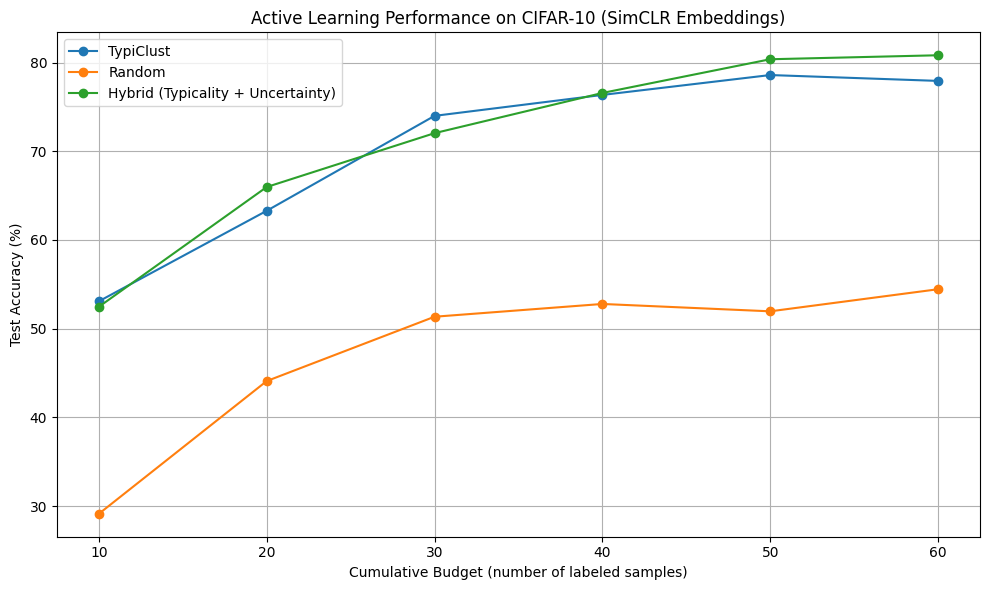

In [20]:
import matplotlib.pyplot as plt

# Assume cum_budget_typiclust, cum_budget_random, cum_budget_hybrid are lists (or arrays)
# that record the cumulative number of labeled samples after each AL iteration.
plt.figure(figsize=(10, 6))
plt.plot(cum_budget_typiclust, [acc * 100 for acc in perf_typiclust], '-o', label="TypiClust")
plt.plot(cum_budget_random, [acc * 100 for acc in perf_random], '-o', label="Random")
plt.plot(cum_budget_hybrid, [acc * 100 for acc in perf_hybrid], '-o', label="Hybrid (Typicality + Uncertainty)")

plt.xlabel("Cumulative Budget (number of labeled samples)")
plt.ylabel("Test Accuracy (%)")
plt.title("Active Learning Performance on CIFAR-10 (SimCLR Embeddings)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
from scipy.stats import ttest_rel
from sklearn.metrics import auc

# Convert performance lists to numpy arrays
typiclust_arr = np.array(perf_typiclust)
random_arr = np.array(perf_random)
hybrid_arr = np.array(perf_hybrid)

# Compute t-test between TypiClust and Random
t_stat_typi_vs_rand, p_val_typi_vs_rand = ttest_rel(typiclust_arr, random_arr)

# Compute t-test between Hybrid and Random
t_stat_hybrid_vs_rand, p_val_hybrid_vs_rand = ttest_rel(hybrid_arr, random_arr)

# Compute t-test between TypiClust and Hybrid
t_stat_typi_vs_hybrid, p_val_typi_vs_hybrid = ttest_rel(typiclust_arr, hybrid_arr)

# Compute AUC for each method
x = np.array(cum_budget_typiclust)  # Same x-axis for all
auc_typiclust = auc(x, typiclust_arr)
auc_random = auc(x, random_arr)
auc_hybrid = auc(x, hybrid_arr)

# Print results
print("\n📊 Statistical Comparison (1 Run):")
print("T-test: TypiClust vs Random -> t = {:.4f}, p = {:.4f}".format(t_stat_typi_vs_rand, p_val_typi_vs_rand))
print("T-test: Hybrid vs Random    -> t = {:.4f}, p = {:.4f}".format(t_stat_hybrid_vs_rand, p_val_hybrid_vs_rand))
print("T-test: TypiClust vs Hybrid -> t = {:.4f}, p = {:.4f}".format(t_stat_typi_vs_hybrid, p_val_typi_vs_hybrid))

print("\n📈 AUC Scores:")
print("TypiClust AUC = {:.4f}".format(auc_typiclust))
print("Random    AUC = {:.4f}".format(auc_random))
print("Hybrid    AUC = {:.4f}".format(auc_hybrid))



📊 Statistical Comparison (1 Run):
T-test: TypiClust vs Random -> t = 23.6722, p = 0.0000
T-test: Hybrid vs Random    -> t = 20.5883, p = 0.0000
T-test: TypiClust vs Hybrid -> t = -1.0535, p = 0.3403

📈 AUC Scores:
TypiClust AUC = 35.7730
Random    AUC = 24.1995
Hybrid    AUC = 36.1595


In [23]:
import csv

# Define the results file path
stats_path = "results/statistical_analysis_summary.csv"
os.makedirs("results", exist_ok=True)

# Open and write to the CSV file
with open(stats_path, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Comparison", "t-statistic", "p-value"])
    writer.writerow(["TypiClust vs Random", t_stat_typi_vs_rand, p_val_typi_vs_rand])
    writer.writerow(["Hybrid vs Random", t_stat_hybrid_vs_rand, p_val_hybrid_vs_rand])
    writer.writerow(["TypiClust vs Hybrid", t_stat_typi_vs_hybrid, p_val_typi_vs_hybrid])

    writer.writerow([])  # Empty row for separation
    writer.writerow(["Method", "AUC Score"])
    writer.writerow(["TypiClust", auc_typiclust])
    writer.writerow(["Random", auc_random])
    writer.writerow(["Hybrid", auc_hybrid])

print(f"\n📁 Statistical results saved to: {stats_path}")



📁 Statistical results saved to: results/statistical_analysis_summary.csv


In [15]:


num_runs = 5

cum_budget_typiclust_all = []
perf_typiclust_all = []
cum_budget_random_all = []
perf_random_all = []
perf_hybrid_all = []
cum_budget_hybrid_all = []

print("Running experiments for TPCRP (TypiClust) selection:")
for run in range(num_runs):
    print(f"\nTPCRP Run {run+1}/{num_runs}")
    cum_budget, perf = run_active_learning(typiclust_selection, budget_per_iter, num_iterations, max_clusters)
    cum_budget_typiclust_all.append(cum_budget)
    perf_typiclust_all.append(perf)

print("\nRunning experiments for Random selection:")
for run in range(num_runs):
    print(f"\nRandom Run {run+1}/{num_runs}")
    cum_budget, perf = run_active_learning(random_selection, budget_per_iter, num_iterations, max_clusters)
    cum_budget_random_all.append(cum_budget)
    perf_random_all.append(perf)
print("Running experiments for Hybrid selection:")
for run in range(num_runs):
    print(f"\nHybrid Run {run+1}/{num_runs}")
    cum_budget_hybrid, perf_hybrid = run_active_learning(hybrid_selection, budget_per_iter, num_iterations, max_clusters)
    perf_hybrid_all.append(perf)

cum_budget_typiclust_all = np.array(cum_budget_typiclust_all)
perf_typiclust_all = np.array(perf_typiclust_all)
cum_budget_random_all = np.array(cum_budget_random_all)
perf_random_all = np.array(perf_random_all)

# Compute mean and standard error (SE) across runs for each iteration.
mean_budget_tpcr = np.mean(cum_budget_typiclust_all, axis=0)
se_budget_tpcr = np.std(cum_budget_typiclust_all, axis=0, ddof=1) / math.sqrt(num_runs)
mean_perf_tpcr = np.mean(perf_typiclust_all, axis=0)
se_perf_tpcr = np.std(perf_typiclust_all, axis=0, ddof=1) / math.sqrt(num_runs)

mean_budget_rand = np.mean(cum_budget_random_all, axis=0)
se_budget_rand = np.std(cum_budget_random_all, axis=0, ddof=1) / math.sqrt(num_runs)
mean_perf_rand = np.mean(perf_random_all, axis=0)
se_perf_rand = np.std(perf_random_all, axis=0, ddof=1) / math.sqrt(num_runs)

# Plotting the mean test accuracy with standard error bars.
plt.figure(figsize=(10, 6))
iterations = np.arange(1, num_iterations+1)

perf_typiclust_all = np.array(perf_typiclust_all)
perf_random_all = np.array(perf_random_all)
perf_hybrid_all = np.array(perf_hybrid_all)


Running experiments for TPCRP (TypiClust) selection:

TPCRP Run 1/5

Active Learning Iteration 1/6
Current labeled samples: 0
Current unlabeled samples: 50000
Unlabeled embeddings shape: (50000, 512)
Selected indices in this iteration: [30570, 2814, 19030, 42315, 4850, 41088, 8133, 32109, 29916, 26299]
Selected indices in this iteration: [30570, 2814, 19030, 42315, 4850, 41088, 8133, 32109, 29916, 26299]
Total labeled samples after iteration 1: 10
Epoch 10/200: Loss = 0.0579, Test Accuracy = 47.68%
Epoch 20/200: Loss = 0.0023, Test Accuracy = 47.83%
Epoch 30/200: Loss = 0.0007, Test Accuracy = 48.14%
Epoch 40/200: Loss = 0.0004, Test Accuracy = 48.20%
Epoch 50/200: Loss = 0.0004, Test Accuracy = 48.23%
Epoch 60/200: Loss = 0.0003, Test Accuracy = 48.30%
Epoch 70/200: Loss = 0.0003, Test Accuracy = 48.23%
Epoch 80/200: Loss = 0.0003, Test Accuracy = 48.18%
Epoch 90/200: Loss = 0.0003, Test Accuracy = 48.14%
Epoch 100/200: Loss = 0.0003, Test Accuracy = 48.15%
Epoch 110/200: Loss = 0.000

<Figure size 1000x600 with 0 Axes>

In [ ]:
import numpy as np
import scipy.stats as stats
import csv
import matplotlib.pyplot as plt
import os
import math

# --- Helper function to compute AUC ---
def compute_auc(results, budget_per_iter):
    """
    Compute the area under the curve (AUC) for each run using the trapezoidal rule.
    Args:
        results: numpy array of shape (n_runs, n_iterations)
        budget_per_iter: the labeled budget increment per iteration.
    Returns:
        A 1D numpy array with the AUC for each run.
    """
    aucs = []
    n_iterations = results.shape[1]
    budgets = np.arange(1, n_iterations + 1) * budget_per_iter
    for run in range(results.shape[0]):
        auc = np.trapz(results[run], budgets)
        aucs.append(auc)
    return np.array(aucs)

# --- Compute AUC for each method ---
auc_hybrid = compute_auc(perf_hybrid_all, budget_per_iter)
auc_typiclust = compute_auc(perf_typiclust_all, budget_per_iter)
auc_random = compute_auc(perf_random_all, budget_per_iter)

print("AUC (Hybrid): {:.4f} ± {:.4f}".format(np.mean(auc_hybrid), np.std(auc_hybrid, ddof=1)))
print("AUC (Typiclust): {:.4f} ± {:.4f}".format(np.mean(auc_typiclust), np.std(auc_typiclust, ddof=1)))
print("AUC (Random): {:.4f} ± {:.4f}".format(np.mean(auc_random), np.std(auc_random, ddof=1)))

# --- Paired t-tests on final iteration accuracies ---
final_hybrid = perf_hybrid_all[:, -1]
final_typiclust =perf_typiclust_all[:, -1]
final_random = perf_random_all[:, -1]

t_stat, p_val = stats.ttest_rel(final_typiclust, final_random)
print("\nPaired t-test (Typiclust vs Random): t = {:.4f}, p = {:.4f}".format(t_stat, p_val))

t_stat, p_val = stats.ttest_rel(final_typiclust, final_hybrid)
print("Paired t-test (Typiclust vs Hybrid): t = {:.4f}, p = {:.4f}".format(t_stat, p_val))

t_stat, p_val = stats.ttest_rel(final_random, final_hybrid)
print("Paired t-test (Random vs Hybrid): t = {:.4f}, p = {:.4f}".format(t_stat, p_val))

# --- Friedman test across the three methods ---
friedman_stat, friedman_p = stats.friedmanchisquare(final_typiclust, final_random, final_hybrid)
print("\nFriedman test: statistic = {:.4f}, p = {:.4f}".format(friedman_stat, friedman_p))

# --- Save statistics to a CSV file ---
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)
stats_filename = os.path.join(results_dir, "active_learning_statistics.csv")
with open(stats_filename, "w", newline="") as csvfile:
    fieldnames = ["Metric", "Hybrid", "Typiclust", "Random"]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerow({
        "Metric": "AUC (mean ± std)",
        "Hybrid": f"{np.mean(auc_hybrid):.4f} ± {np.std(auc_hybrid, ddof=1):.4f}",
        "Typiclust": f"{np.mean(auc_typiclust):.4f} ± {np.std(auc_typiclust, ddof=1):.4f}",
        "Random": f"{np.mean(auc_random):.4f} ± {np.std(auc_random, ddof=1):.4f}"
    })
    writer.writerow({
        "Metric": "Final Accuracy (mean ± std)",
        "Hybrid": f"{np.mean(final_hybrid)*100:.2f}% ± {np.std(final_hybrid, ddof=1)*100:.2f}%",
        "Typiclust": f"{np.mean(final_typiclust)*100:.2f}% ± {np.std(final_typiclust, ddof=1)*100:.2f}%",
        "Random": f"{np.mean(final_random)*100:.2f}% ± {np.std(final_random, ddof=1)*100:.2f}%"
    })
    writer.writerow({
        "Metric": "Paired t-test (Typiclust vs Random) p-value",
        "Hybrid": "",
        "Typiclust": "",
        "Random": f"{p_val:.4f}"  # Adjust if needed (this is the last computed p-value)
    })
    writer.writerow({
        "Metric": "Friedman test p-value",
        "Hybrid": "",
        "Typiclust": "",
        "Random": f"{friedman_p:.4f}"
    })

print(f"Statistics saved to {stats_filename}")

# --- Plotting the results using cumulative budget on the x-axis ---
cumulative_budget = np.arange(1, num_iterations + 1) * budget_per_iter

plt.figure(figsize=(10, 6))
# Compute means and standard errors for each method.
mean_tpcr = np.mean(perf_typiclust_all, axis=0)
se_tpcr = np.std(perf_typiclust_all, axis=0, ddof=1) / math.sqrt(perf_typiclust_all.shape[0])
mean_rand = np.mean(perf_random_all, axis=0)
se_rand = np.std(perf_random_all, axis=0, ddof=1) / math.sqrt(perf_random_all.shape[0])
mean_hybrid = np.mean(perf_hybrid_all, axis=0)
se_hybrid = np.std(perf_hybrid_all, axis=0, ddof=1) / math.sqrt(perf_hybrid_all.shape[0])

plt.errorbar(cumulative_budget, mean_tpcr * 100, yerr=se_tpcr * 100, fmt='-o', capsize=5, label="Typiclust")
plt.errorbar(cumulative_budget, mean_rand * 100, yerr=se_rand * 100, fmt='-s', capsize=5, label="Random")
plt.errorbar(cumulative_budget, mean_hybrid * 100, yerr=se_hybrid * 100, fmt='-^', capsize=5, label="Hybrid")
plt.xlabel("Cumulative Labeled Budget")
plt.ylabel("Test Accuracy (%)")
plt.title("Active Learning Performance (Fully Supervised with Self-Supervised Embeddings)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "performance_plot_cumulative_budget.png"))
plt.show()
